In [1]:
import pandas as pd
from safegraph_py_functions import safegraph_py_functions as sgpy
import os
from dotenv import load_dotenv, find_dotenv
import zipfile
import datetime

In [2]:
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)
root_dir = os.environ.get("ROOT_DIR")
raw_data_dir = os.path.join(root_dir,'data/raw')

In [3]:
# Read in all patterns files in the monthly-patterns folder

patterns_path = os.path.join(raw_data_dir,'monthly-patterns')
files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(patterns_path):
    for file in f:
        if file.endswith('.csv.gz') and 'patterns-part' in file:
            files.append(os.path.join(patterns_path, r, file))

In [4]:
processed_data_dir = os.path.join(root_dir,'data/processed')
philly_places = pd.read_csv(os.path.join(processed_data_dir,'philly_places.csv'))

In [5]:
for col in ['valid_to', 'valid_from']:
    philly_places[col] = pd.to_datetime(philly_places[col])

In [7]:
# columns that we keep and aggregate
keep_cols = ['postal_code', 'safegraph_place_id', 'date_range_start', 'visits_by_day']
# columns we keep after exploding
keep_cols_2 = ['postal_code', 'top_category', 'date','visits']
# columns to group by
group_by_cols = ['postal_code', 'top_category', 'date']

def filter_and_explode(file):
    df = pd.read_csv(file)
    df = df[keep_cols]
    # zip codes are read as integers rather than strings so we add leading zeros.
    df['postal_code'] = df['postal_code'].apply(lambda x: ('00000' + str(x))[-5:])
    # then we select the Philadelphia zipcodes
    in_philly = df['postal_code'].str.startswith("191")
    df = df.loc[in_philly]
    df = df.reset_index(drop = True)
    df['date_range_start'] = pd.to_datetime(
        df['date_range_start'].apply(lambda x: x[:10])
    )
    if len(df['date_range_start'].unique()) > 1:
        print('More than one date in {0}!'.format(file))
    file_date = df.loc[0,'date_range_start']
    current = (philly_places['valid_from'] <= file_date) & (philly_places['valid_to'] > file_date)
    current_places = philly_places.loc[current, ['safegraph_place_id','top_category']]
    df = df.merge(current_places, how = 'left')
    # The visits_by_day column contains a list of integers. 
    # This explodes that list so we get one row per day.
    df = sgpy.explode_json_array(
        df, array_column ='visits_by_day', value_col_name='visits', 
        place_key='safegraph_place_id', file_key='date_range_start', array_sequence='day', 
        keep_index=False, zero_index=False)
    df['date_range_start'] = pd.to_datetime(df['date_range_start'])
    # Calculate the date for each row.
    temp = df['day'].apply(lambda x: pd.Timedelta(x-1, unit='D'))
    df['date'] = df['date_range_start'] + temp
    df = df[keep_cols_2].groupby(group_by_cols).agg('sum').reset_index()
    return df

In [8]:
test = filter_and_explode(files[0])

In [9]:
test.head()

,postal_code,top_category,date,visits
0,19102,Automobile Dealers,2020-10-01,2
1,19102,Automobile Dealers,2020-10-02,0
2,19102,Automobile Dealers,2020-10-03,3
3,19102,Automobile Dealers,2020-10-04,0
4,19102,Automobile Dealers,2020-10-05,0


In [10]:
traffic = pd.concat([filter_and_explode(file) for file in files])

In [11]:
traffic.dtypes

postal_code             object
top_category            object
date            datetime64[ns]
visits                   int64
dtype: object

In [46]:
traffic_by_day = (
    traffic[['date','top_category','visits']].groupby(['date','top_category']).agg('sum')
)
traffic_by_day['total_visits'] = traffic_by_day.groupby('date')['visits'].transform('sum')
traffic_by_day = traffic_by_day.reset_index()

In [47]:
traffic_by_day['percent_visits'] = 100*traffic_by_day['visits']/traffic_by_day['total_visits']
traffic_by_day['peak_percent'] = (
    traffic_by_day.groupby('top_category')['percent_visits'].transform('max')
)
traffic_by_day['Category'] = traffic_by_day['top_category']
small_cats = traffic_by_day['peak_percent'] < 5
traffic_by_day.loc[small_cats,'Category'] = 'Other'

In [48]:
traffic_by_day = traffic_by_day[['date', 'Category', 'visits']].groupby(['date','Category']).agg('sum')
traffic_by_day['total_visits'] = traffic_by_day.groupby('date')['visits'].transform('sum')
traffic_by_day = traffic_by_day.reset_index()
traffic_by_day['percent_visits'] = 100*traffic_by_day['visits']/traffic_by_day['total_visits']

In [49]:
traffic_by_day.Category.unique()

array(['Elementary and Secondary Schools', 'Gasoline Stations',
       'Grocery Stores', 'Junior Colleges', 'Lessors of Real Estate',
       'Museums, Historical Sites, and Similar Institutions',
       'Office Supplies, Stationery, and Gift Stores', 'Other',
       'Other Amusement and Recreation Industries',
       'Restaurants and Other Eating Places', 'Spectator Sports',
       'Support Activities for Air Transportation'], dtype=object)

In [50]:
original_to_display_name = {
   'Other':'Other', 
    'Elementary and Secondary Schools': 'Schools', 
    'Gasoline Stations': 'Gas Stations',
    'Grocery Stores':'Grocery Stores', 
    'Junior Colleges': 'Junior Colleges', 
    'Lessors of Real Estate': 'Real Estate',
    'Museums, Historical Sites, and Similar Institutions': 'Museums and Sites',
    'Office Supplies, Stationery, and Gift Stores': 'Office Supplies',
    'Other Amusement and Recreation Industries': 'Amusement and Recreation',
    'Restaurants and Other Eating Places': 'Restaurants', 
    'Spectator Sports': 'Spectator Sports',
    'Support Activities for Air Transportation': 'Air Transportation' 
}

In [51]:
traffic_by_day['Category'] = traffic_by_day['Category'].apply(
    lambda x: original_to_display_name[x]
)

In [52]:
import hvplot.pandas 

In [55]:
min_date = pd.to_datetime('2020-09-01')
max_date = pd.to_datetime('2020-12-01')

dates = (traffic_by_day['date'] < max_date) & (traffic_by_day['date'] >= min_date)
data = traffic_by_day[dates]
ticks = list(traffic_by_day[traffic_by_day['date'].dt.day == 1]['date'])
table = (
    traffic_by_day.loc[dates,['date', 'Category','percent_visits']].groupby(['date', 'Category']).sum()
)

In [57]:
table.hvplot.bar(stacked=True, height=500, legend='top_left')

:Bars   [date,Category]   (percent_visits)

In [62]:
# pull all the normalization_stats files in monthly-patterns
patterns_path = os.path.join(raw_data_dir,'monthly-patterns')
# print(local)
files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(patterns_path):
    for file in f:
        if 'normalization_stats.csv' in file:
            files.append(os.path.join(patterns_path, r, file))

#print(files)

In [63]:
# for files with information disaggregated at the state level, keep only the country-wide info
def keep_total_level(norm_stats):
    if 'region' in norm_stats.columns:
        if len(norm_stats[norm_stats['region'] == 'ALL_STATES']) == 0:
            raise ValueError('no region named "ALL_STATES"')
        norm_stats = norm_stats[norm_stats['region'] == 'ALL_STATES']
        norm_stats = norm_stats.drop(columns = ['region'])
    return norm_stats

In [64]:
norm_stats = pd.concat([keep_total_level(pd.read_csv(file)) for file in files])
norm_stats['year'] = norm_stats['year'].astype(int)
norm_stats['month'] = norm_stats['month'].astype(int)
norm_stats['day'] = norm_stats['day'].astype(int)
# HK: I only downloaded patterns data from 2019 onwards due to memory constraints
norm_stats = norm_stats[norm_stats['year'] >= 2019]

In [65]:
traffic_by_day['year'] = traffic_by_day['date'].dt.year
traffic_by_day['month'] = traffic_by_day['date'].dt.month
traffic_by_day['day'] = traffic_by_day['date'].dt.day

KeyError: 'date'

In [60]:
traffic_by_day = traffic_by_day.drop(columns = ['date'])

In [66]:
traffic_by_day = traffic_by_day.merge(norm_stats, on = ['year','month','day'])

In [67]:
traffic_by_month = traffic_by_day.groupby(['year','month','Category']).agg('mean').reset_index()

In [70]:
traffic_by_month

,year,month,Category,visits,total_visits_x,percent_visits,day,total_visits_y,total_devices_seen,total_home_visits,total_home_visitors
0,2019,1,Air Transportation,7592.806452,180864.677419,4.280015,16.0,5.540737e+07,1.842444e+07,2.274175e+07,1.400512e+07
1,2019,1,Amusement and Recreation,11220.161290,180864.677419,6.215223,16.0,5.540737e+07,1.842444e+07,2.274175e+07,1.400512e+07
2,2019,1,Gas Stations,4674.774194,180864.677419,2.585178,16.0,5.540737e+07,1.842444e+07,2.274175e+07,1.400512e+07
3,2019,1,Grocery Stores,9971.193548,180864.677419,5.547718,16.0,5.540737e+07,1.842444e+07,2.274175e+07,1.400512e+07
4,2019,1,Junior Colleges,5215.387097,180864.677419,2.789561,16.0,5.540737e+07,1.842444e+07,2.274175e+07,1.400512e+07
...,...,...,...,...,...,...,...,...,...,...,...
259,2020,10,Other,33300.225806,87953.935484,37.835758,16.0,5.281370e+07,1.702610e+07,2.378817e+07,1.399651e+07
260,2020,10,Real Estate,6889.967742,87953.935484,7.852296,16.0,5.281370e+07,1.702610e+07,2.378817e+07,1.399651e+07
261,2020,10,Restaurants,19959.129032,87953.935484,22.687640,16.0,5.281370e+07,1.702610e+07,2.378817e+07,1.399651e+07
262,2020,10,Schools,2704.580645,87953.935484,3.071954,16.0,5.281370e+07,1.702610e+07,2.378817e+07,1.399651e+07


In [72]:
traffic_by_month['visits_normalized'] = traffic_by_month['visits']/traffic_by_month['total_devices_seen']

In [74]:
# Due to long-term changes in the panel (e.g. more devices being tracked over time), 
# we might want to look at visits relative to January of the same year.
traffic_by_month = traffic_by_month.merge(traffic_by_month[traffic_by_month['month'] == 1],  on = ['year','Category'], suffixes = ("","_jan"))
traffic_by_month['visits_relative'] = traffic_by_month['visits']/traffic_by_month['visits']
traffic_by_month['visits_normalized_relative'] = traffic_by_month['visits_normalized']/traffic_by_month['visits_normalized_jan']
traffic_by_month = traffic_by_month.drop(
    columns = [col for col in traffic_by_month.columns if col.endswith('_jan')]
)

In [75]:
# ultimately we want to compare 2020 to 2019 to get at the impact of COVID-19
traffic_by_month = traffic_by_month[traffic_by_month['year'] == 2020].merge(
    traffic_by_month[traffic_by_month['year'] == 2019], 
    on = ['month','Category'], 
    suffixes = ("_2020","_2019"))
traffic_by_month = traffic_by_month.drop(columns = ['year_2020','year_2019'])

In [76]:
# Because the normalized or relative visit counts are hard to interpret,
# we will plot percent differences instead of absolute differences.
metrics = ['visits', 'visits_normalized', 'visits_relative', 'visits_normalized_relative']
for metric in metrics:
    plot_col = metric + '_dif'
    traffic_by_month[plot_col] = traffic_by_month[metric+'_2020'] - traffic_by_month[metric + '_2019']
    plot_col = plot_col + '_pct'
    traffic_by_month[plot_col] = (100*traffic_by_month[metric+'_dif'])/traffic_by_month[metric + '_2019']

In [77]:
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import hvplot.pandas
import geopandas as gpd
import urllib.request
import json

In [84]:
import panel as pn
import param as pm
from matplotlib import pyplot as plt

In [93]:
# HK: I would like to have checkboxes for 'normalized by devices seen' and 'relative to January'
#     but don't know how to give the checkbox a name (I was looking at pm.Boolean()).
class Change_visits(pm.Parameterized):
    df = traffic_by_month
    variable = pm.Selector(
        objects = ['visits', 'visits_normalized', 'visits_relative', 'visits_normalized_relative'], 
        default = 'visits_normalized_relative', allow_None = False)
    month = pm.Integer(
        2, bounds = (min(df['month']), max(df['month']))
    )
    
    @pm.depends('variable')
    def make_subtitle(self):
        return 'Percent change in ' + self.variable + ' with respect to 2019'
    
    @pm.depends('df', 'month')
    def filter_month(self):
        mask = self.df['month'] == self.month
        return self.df.loc[mask]
        
    @pm.depends('df', 'variable', 'month')
    def make_plot(self):
        filtered = self.filter_month()
        #return filtered[['svcg_cycle_date', 'pct_missing']].hvplot(kind='line')
        # Create the figure
        fig, ax = plt.subplots(facecolor="lightgray", figsize=(8, 8))

        # Plot
        col = self.variable + '_dif'+'_pct'
        
        x = filtered['Category']
        y = filtered[col]

        x_pos = [i for i, _ in enumerate(x)]

        ax.bar(x_pos, y, color='blue')
        ax.set_xlabel("Location category")
        ax.set_ylabel("Percent change in " + col)
        ax.set_title("Traffic impact by category")

        ax.set_xticks(x_pos)
        ax.set_xticklabels(x)
        
        return fig

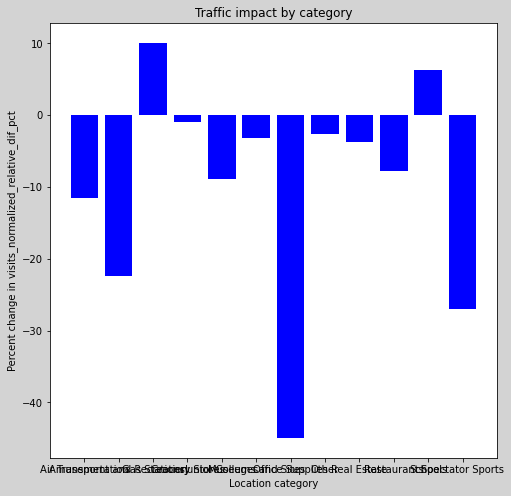

In [94]:
app = Change_visits(name = "")
title = '### Impact on foot traffic'
traffic_panel = pn.Column(
    pn.Row(
        pn.Column(title, app.make_subtitle, pn.Param(app.param))
    ), app.make_plot )

Column
    [0] Row
        [0] Column
            [0] Markdown(str)
            [1] ParamMethod(method)
            [2] Param(Change_visits)
    [1] ParamMethod(method)
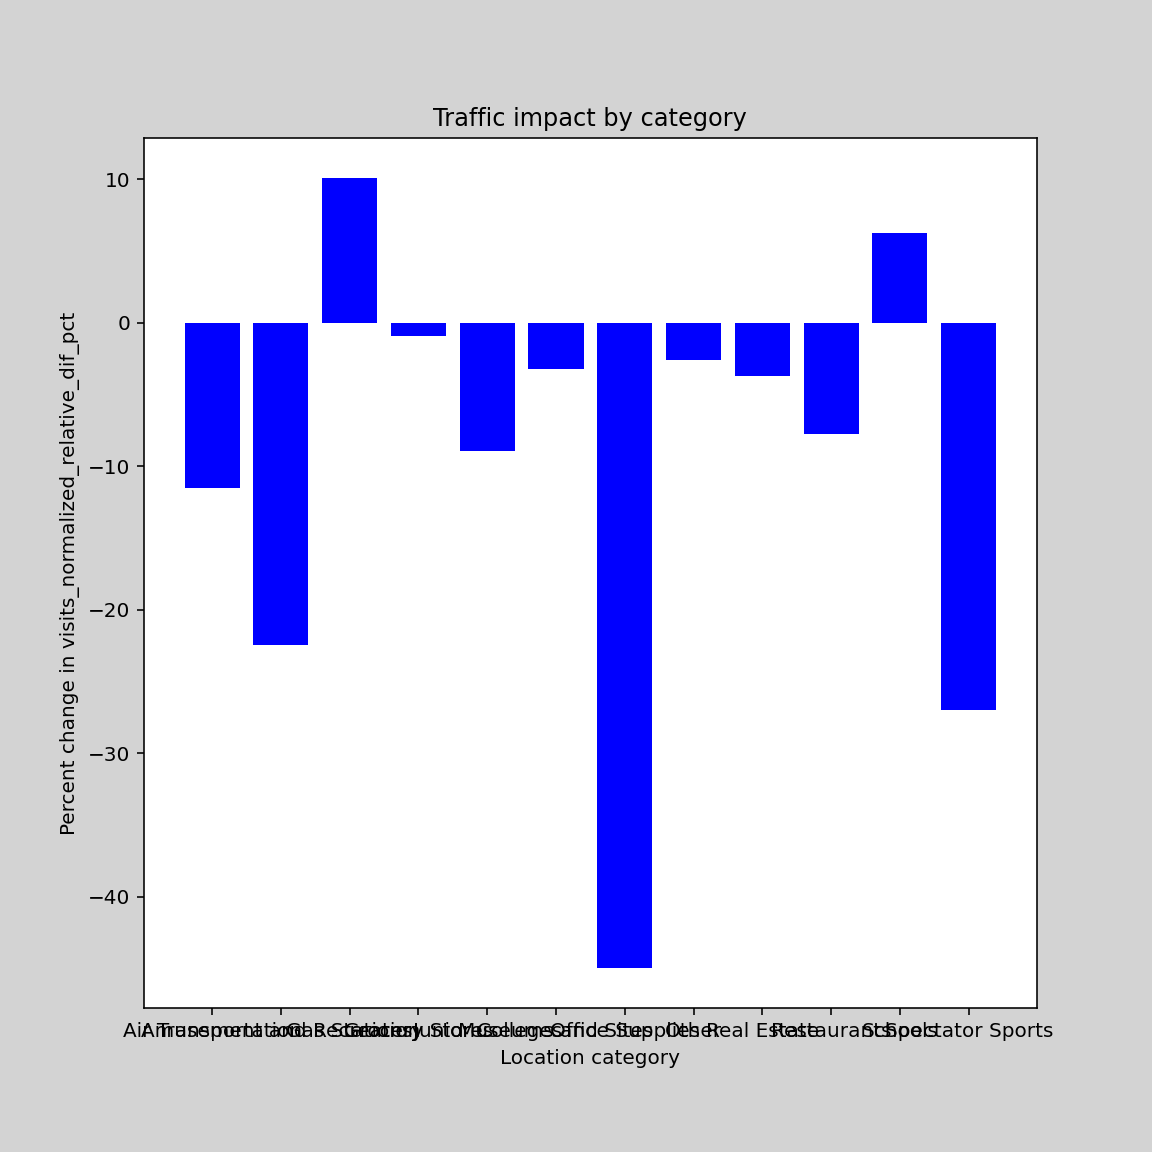

In [95]:
traffic_panel